In [84]:
from annoy import AnnoyIndex
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pprint
import pandas as pd

In [85]:
df = pd.read_parquet('data-val.parquet')

In [86]:
df.head()
print(df.shape)
# for col in df.columns.sort_values():
#     print(col)

(136710, 57)


In [87]:
# Dropping columns
df = df.drop(columns=['Age_x','CIF_CLSCUS', 'COB_DATE', 'DATE_TIME', 'BRN_OPN_CIF', 'MA_PHONG_GIAO_DICH_VCB', 'CIF_MASK', 'IS_TM', 'Unnamed: 0', 'SUM_CBALQ_LH_6m', 'SUM_CBALQ_LH_3m', 'AVG_GR_SUM_CBALQ_LH'])

In [88]:
print(df.shape)


(136710, 45)


In [89]:
# Identify binary columns (1, 0, and NaN)
binary_columns = df.columns[
    df.apply(lambda col: col.dropna().isin([0, 1]).all())
]

# Replace 1 -> True, 0 -> False in binary columns (NaN remains as is)
df[binary_columns] = (
    df[binary_columns].replace({1: True, 0: False}).astype("boolean")  # Boolean with NaN support
)


# Separate numerical columns
numerical_vars = df.select_dtypes(include=['number'])

# Separate categorical columns
categorical_vars = df.select_dtypes(include=['object', 'category', 'boolean'])

print (numerical_vars.shape[1] + categorical_vars.shape[1])


/tmp/ipykernel_28558/3481204619.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_columns].replace({1: True, 0: False}).astype("boolean")  # Boolean with NaN support


45


In [90]:
print("\nCategories in Categorical Columns:")
for col in categorical_vars.columns.sort_values():
    unique_vals = df[col].unique()
    print(f"{col}: Unique Values = {unique_vals}\n")


Categories in Categorical Columns:
BHNT_after21: Unique Values = <BooleanArray>
[<NA>, True, False]
Length: 3, dtype: boolean

BHNT_flag: Unique Values = <BooleanArray>
[<NA>, True, False]
Length: 3, dtype: boolean

BHNT_remain: Unique Values = <BooleanArray>
[<NA>, True, False]
Length: 3, dtype: boolean

BHSK_after21: Unique Values = <BooleanArray>
[<NA>, False, True]
Length: 3, dtype: boolean

BHSK_flag: Unique Values = <BooleanArray>
[<NA>, False, True]
Length: 3, dtype: boolean

BHSK_remain: Unique Values = <BooleanArray>
[<NA>, False, True]
Length: 3, dtype: boolean

CUS_GEN: Unique Values = ['F' 'M' ' ']

IS_BANCAS: Unique Values = <BooleanArray>
[True, False]
Length: 2, dtype: boolean

IS_TA: Unique Values = <BooleanArray>
[True, False]
Length: 2, dtype: boolean

IS_TM.1: Unique Values = <BooleanArray>
[True, False]
Length: 2, dtype: boolean

Khu_vuc: Unique Values = ['ĐNB' 'Tp.HCM' 'TNB' 'HN' 'ĐBSH' 'NTBTN' 'BTTB' 'TDMNPB']

LOAIHINHCOQUANDANGCONGTAC: Unique Values = [None 'Cá

In [91]:
print("Range of Numerical Columns:")
for col in numerical_vars.columns.sort_values():
    min_val = df[col].min()
    max_val = df[col].max()
    print(f"{col}: Min = {min_val}, Max = {max_val}, \n")



Range of Numerical Columns:
AVG_AMT_3M: Min = 1.0, Max = 658602521.0, 

AVG_CBALQ_3m: Min = 0.0, Max = 13358970808.7, 

AVG_CBALQ_6m: Min = -15065839.833333334, Max = 8544798910.178349, 

AVG_CBALQ_TGCCKH: Min = 1.0, Max = 39900000000.0, 

AVG_GR_CBALQ: Min = -0.9961425142537732, Max = inf, 

AVG_GR_THGCO: Min = -0.999359697889346, Max = inf, 

AVG_GR_THGNO: Min = -0.9972551805575024, Max = inf, 

AVG_SL_SP_BOSUNG: Min = 0.0, Max = 7.0, 

Age_y: Min = 0.0, Max = 170.0, 

CBALQ_3m: Min = 0.0, Max = 40076912426.1, 

CBALQ_6m: Min = -90395039.0, Max = 51268793461.0701, 

CNT_TGCCKH: Min = 0.0, Max = 43.0, 

MEDIAN_GR_CBALQ: Min = -0.9999966666722222, Max = inf, 

MEDIAN_GR_SUM_AMT: Min = -0.9881516587677726, Max = inf, 

MEDIAN_GR_THGCO: Min = -0.9999999999440036, Max = inf, 

MEDIAN_GR_THGNO: Min = -0.9999987150886764, Max = inf, 

NO_TREN_CO_3m: Min = 0.0, Max = inf, 

NO_TREN_CO_6m: Min = 0.0, Max = inf, 

SUM_CBALQ_LH: Min = 0.0, Max = 200956130344.0, 

Snapshot: Min = 202211.0, Max =

In [92]:
def labelling (df, col, num_bins):
    df[col] = pd.qcut(df[col], q=num_bins, labels=False, duplicates='drop')
    return df

for col in ['AVG_AMT_3M', 'AVG_CBALQ_3m', 'AVG_CBALQ_6m', 'AVG_CBALQ_TGCCKH',
       'AVG_GR_CBALQ', 'AVG_GR_THGCO', 'AVG_GR_THGNO', 'AVG_SL_SP_BOSUNG',
        'CBALQ_3m', 'CBALQ_6m', 'CNT_TGCCKH', 'MEDIAN_GR_CBALQ',
       'MEDIAN_GR_SUM_AMT', 'MEDIAN_GR_THGCO', 'MEDIAN_GR_THGNO',
       'NO_TREN_CO_3m', 'NO_TREN_CO_6m', 'SUM_CBALQ_LH', 'Snapshot', 'Sum_PPC',
       'THGCO_3m', 'THGCO_6m', 'THGNO_3m', 'THGNO_6m', 'TONGTHUNHAPHANGTHANG']:
    df = labelling(df, col, 10)

age_bin_edges = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, float('inf')]
labels = ['Duoi 20', '20 toi 24', '25 toi 29', '30 toi 34', '35 toi 39', '40 toi 44', '45 toi 49', '50 toi 54', '55 toi 59', 'Tren 60']

df['Age_group'] = pd.cut(df['Age_y'], bins=age_bin_edges, labels=labels, right=False)

# Dropping age 
df=df.drop(columns=['Age_y'])

# Bins
print("\nCategories in DataFrame after binning:")
for col in df.columns.sort_values():
    unique_vals = df[col].unique()
    print(f"{col}: Unique Values = {unique_vals}\n")

/home/zeus/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/zeus/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/zeus/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/zeus/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/zeus/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/zeus/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtrac


Categories in DataFrame after binning:
AVG_AMT_3M: Unique Values = [ 8. nan  9.  5.  6.  2.  0.  3.  7.  1.  4.]

AVG_CBALQ_3m: Unique Values = [ 8.  7.  4.  9.  1.  6.  5.  2.  3.  0. nan]

AVG_CBALQ_6m: Unique Values = [ 7.  5.  9.  3.  1.  4.  8.  6.  0.  2. nan]

AVG_CBALQ_TGCCKH: Unique Values = [ 8. nan  0.  7.  3.  4.  9.  6.  2.  5.  1.]

AVG_GR_CBALQ: Unique Values = [ 6.  1.  8.  2.  7.  0.  5.  9. nan  3.  4.]

AVG_GR_THGCO: Unique Values = [ 2.  0.  4.  5.  8.  7.  3.  6.  1. nan]

AVG_GR_THGNO: Unique Values = [ 5.  0.  3.  6.  4.  1.  7.  2. nan]

AVG_SL_SP_BOSUNG: Unique Values = [nan  1.  0.  2.  3.]

Age_group: Unique Values = ['35 toi 39', '45 toi 49', '30 toi 34', 'Tren 60', '20 toi 24', '50 toi 54', '25 toi 29', '40 toi 44', '55 toi 59', 'Duoi 20']
Categories (10, object): ['Duoi 20' < '20 toi 24' < '25 toi 29' < '30 toi 34' ... '45 toi 49' < '50 toi 54' < '55 toi 59' < 'Tren 60']

BHNT_after21: Unique Values = <BooleanArray>
[<NA>, True, False]
Length: 3, dtype: b

In [93]:
## Collaborative search




In [94]:
# Step 1: Handle missing values and ensure consistent data types
def handle_missing_values(df):
    df = df.astype(str)
    df = df.fillna("None")
    return df

# Step 2: Preprocess - Encoding categorical variables
def preprocess_data(df, target_column, transformer=None):
    # Separate features (X) and target (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Reset indices for alignment with Annoy
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # Handle missing values and ensure consistent data types
    X = handle_missing_values(X)

    if transformer is None:
        transformer = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), X.columns.tolist())
            ],
            remainder='passthrough'
        )
        transformer.fit(X)
    
    # Transform features
    X_transformed = transformer.transform(X)
    return X_transformed.astype(np.float32), y.astype(float), transformer

# Step 3: Create Annoy Index
def create_annoy_index(df, target_column, n_neighbors=20):
    # Preprocess the data and separate features and target
    X, y, transformer = preprocess_data(df, target_column)
    
    # Initialize Annoy index
    annoy_index = AnnoyIndex(X.shape[1], 'angular')
    
    # Add items to the Annoy index
    for i, vector in enumerate(X):
        annoy_index.add_item(i, vector)
    
    # Build the index
    annoy_index.build(100)
    
    return annoy_index, X, y, transformer  # Return y for later use
    
def predict(df, target_column, annoy_index, transformer, y_train):
    # Preprocess the data and separate features
    X, y, _ = preprocess_data(df, target_column, transformer)
    
    # Prepare an array to hold the predictions
    y_pred = []
    
    # For each test observation, find the 20 nearest neighbors in the train data
    for test_vector in X:
        nearest_neighbors = annoy_index.get_nns_by_vector(test_vector, 20)  # Get indices of 20 nearest neighbors
        similar_train_data = y_train.iloc[nearest_neighbors]  # Use y_train directly
        y_pred_value = similar_train_data.mean()  # Average for prediction
        y_pred.append(y_pred_value)
    
    return np.array(y_pred)


# Example Usage
target_column = 'IS_BANCAS'

# Step 1: Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Reset indices after splitting
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Step 2: Create Annoy Index using the training dataframe
annoy_index, _, y_train, transformer = create_annoy_index(train_df, target_column)

# Step 3: Use the Annoy Index to make predictions on the test dataframe
y_pred = predict(test_df, target_column, annoy_index, transformer, y_train)

# Extract true labels for evaluation
y_test = test_df[target_column].astype(float)



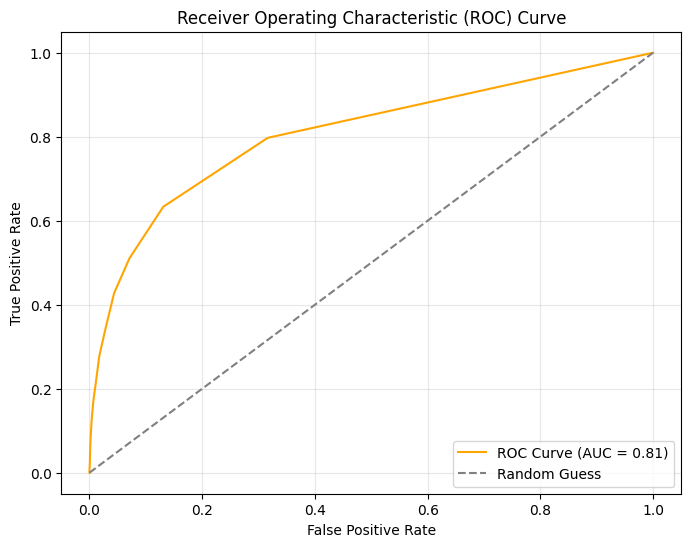

In [99]:

# Step 4: Evaluate predictions (e.g., ROC Curve)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [96]:
y_pred_fin = y_pred.round()
accuracy = accuracy_score(y_test, y_pred_fin)
accuracy = round(accuracy, 4)

auc_ = roc_auc_score(y_test, y_pred_fin)
print("Model Accuracy:", str(accuracy*100) +"%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_fin))

Model Accuracy: 95.26%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98     25995
         1.0       0.69      0.07      0.13      1347

    accuracy                           0.95     27342
   macro avg       0.82      0.53      0.55     27342
weighted avg       0.94      0.95      0.93     27342



In [97]:
roc_auc_score = roc_auc_score(y_test, y_pred)
gini_index = 2 * roc_auc - 1

print("ROC AUC Score:", roc_auc_score.round(2))
print("Gini Index:", gini_index.round(2))

ROC AUC Score: 0.81
Gini Index: 0.61
